# MLP

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
from torch.utils.tensorboard import SummaryWriter

from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

from tqdm import tqdm
from torchinfo import summary

In [2]:
DATA_PATH = "../data/filtered_df.csv"
SAVED_MODELS_PATH = "saved_models/"
RUNS_PATH = "runs/"

In [3]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cpu')

In [4]:
class TemperatureDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        super(TemperatureDataset, self).__init__()

        self.X = torch.from_numpy(X).type(torch.FloatTensor).to(DEVICE)
        self.y = torch.from_numpy(y).type(torch.LongTensor).to(DEVICE)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [5]:
df = pd.read_csv(DATA_PATH, index_col=False)
df = df.sample(frac=1)
df.reset_index(drop=True, inplace=True)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,1432,1433,1434,1435,1436,1437,1438,1439,disease,disease_encoded
0,-0.596810,-0.603499,-0.629674,-0.686768,-0.714473,-0.743524,-0.770487,-0.770972,-0.782348,-0.772732,...,-0.637026,-0.629740,-0.617626,-0.604859,-0.614421,-0.609821,-0.551177,-0.551008,tuberculosis,3
1,0.063518,0.067880,0.047908,0.009884,-0.002818,-0.015834,-0.026005,-0.018394,-0.013580,0.014617,...,0.007068,0.003319,0.001803,0.006697,-0.009119,-0.029259,0.002913,-0.008256,tuberculosis,3
2,-0.772158,-0.758427,-0.764652,-0.805698,-0.817639,-0.832307,-0.845816,-0.833380,-0.833559,-0.813942,...,-0.659361,-0.670224,-0.676881,-0.684352,-0.715458,-0.730034,-0.689956,-0.712528,non-tubercular bacterial infection,2
3,-1.184003,-1.215761,-1.262693,-1.340047,-1.397333,-1.457397,-1.516604,-1.527774,-1.624697,-1.637636,...,-1.496179,-1.465183,-1.506538,-1.544734,-1.621046,-1.640691,-1.611940,-1.669401,dengue,0
4,0.711537,0.716489,0.692864,0.663745,0.656331,0.649800,0.647031,0.654493,0.666713,0.704651,...,0.461699,0.463528,0.465851,0.479131,0.473387,0.448613,0.474214,0.469184,non-infectious diseases,1


In [6]:
X = df.drop("disease", axis=1)
X = X.drop("disease_encoded", axis=1)
y = df["disease_encoded"]

In [7]:
train_data, test_data, train_labels, test_labels = train_test_split(X, y, test_size=0.2, random_state=42)
train_data = train_data.to_numpy()
test_data = test_data.to_numpy()
train_labels = train_labels.to_numpy()
test_labels = test_labels.to_numpy()

In [8]:
train_dataset = TemperatureDataset(train_data, train_labels)
test_dataset = TemperatureDataset(test_data, test_labels)

In [9]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True)

In [10]:
class Model(nn.Module):
  def __init__(self):
    super(Model, self).__init__()

    self.dense = nn.Linear(1440, 4)
    self.softmax = nn.Softmax(dim=1)

  def forward(self, x):
    x = x.to(DEVICE)
    return self.softmax(self.dense(x))

In [14]:
sample_x, sample_y = next(iter(train_loader))

## SGD

In [11]:
model = Model()
model = model.to(DEVICE)
model

Model(
  (dense): Linear(in_features=1440, out_features=4, bias=True)
  (softmax): Softmax(dim=1)
)

In [46]:
summary(model, input_data=sample_x)

Layer (type:depth-idx)                   Output Shape              Param #
Model                                    [8, 4]                    --
├─Linear: 1-1                            [8, 4]                    5,764
├─Softmax: 1-2                           [8, 4]                    --
Total params: 5,764
Trainable params: 5,764
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.05
Input size (MB): 0.05
Forward/backward pass size (MB): 0.00
Params size (MB): 0.02
Estimated Total Size (MB): 0.07

In [12]:
tb_board = RUNS_PATH + "mlp_sgd"
writer = SummaryWriter(tb_board)

In [15]:
writer.add_graph(model, sample_x)

In [16]:
EPOCHS = 200

acc_list = []
f1_list = []
recall_list = []
precision_list = []

loss_list = []

In [17]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)

In [18]:
for epoch in range(EPOCHS):
  model.train()
  running_loss = 0.0

  labels_list = []
  preds_list = []

  for (x, y) in train_loader:
    x, y = x.to(DEVICE), y.to(DEVICE)

    yhat = model(x)

    labels_list.extend(y.cpu())
    preds_list.extend(yhat.argmax(1).cpu())

    loss = loss_fn(yhat, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    running_loss += loss.item()

  avg_loss = running_loss / len(train_loader)
  loss_list.append(avg_loss)

  acc = accuracy_score(labels_list, preds_list)
  pre = precision_score(labels_list, preds_list, average='weighted')
  rec = recall_score(labels_list, preds_list, average='weighted')
  f1 = f1_score(labels_list, preds_list, average='weighted')

  acc_list.append(acc)
  precision_list.append(pre)
  recall_list.append(rec)
  f1_list.append(f1)

  writer.add_scalar("Train/Loss", avg_loss, epoch)
  writer.add_scalar("Train/Accuracy", acc, epoch)
  writer.add_scalar("Train/Precision", pre, epoch)
  writer.add_scalar("Train/Recall", rec, epoch)
  writer.add_scalar("Train/F1", f1, epoch)

  print(f"Epoch: {epoch + 1} - Loss: {avg_loss} - Accuracy: {acc} - Precision: {pre} - Recall: {rec} - F1: {f1}")

Epoch: 1 - Loss: 1.3787939071655273 - Accuracy: 0.33043478260869563 - Precision: 0.34876385336743393 - Recall: 0.33043478260869563 - F1: 0.33139713021900963
Epoch: 2 - Loss: 1.3293552319208781 - Accuracy: 0.391304347826087 - Precision: 0.3900488342785129 - Recall: 0.391304347826087 - F1: 0.36912197229274296
Epoch: 3 - Loss: 1.3080516497294108 - Accuracy: 0.391304347826087 - Precision: 0.37273359333622225 - Recall: 0.391304347826087 - F1: 0.36595441349277663
Epoch: 4 - Loss: 1.278613845507304 - Accuracy: 0.4782608695652174 - Precision: 0.523957189853085 - Recall: 0.4782608695652174 - F1: 0.4749156067127726
Epoch: 5 - Loss: 1.2527139027913412 - Accuracy: 0.4782608695652174 - Precision: 0.5063322007257934 - Recall: 0.4782608695652174 - F1: 0.4677075098814229
Epoch: 6 - Loss: 1.2498289744059246 - Accuracy: 0.5043478260869565 - Precision: 0.5506066734074823 - Recall: 0.5043478260869565 - F1: 0.481715211026059
Epoch: 7 - Loss: 1.2224087158838908 - Accuracy: 0.5130434782608696 - Precision: 0.

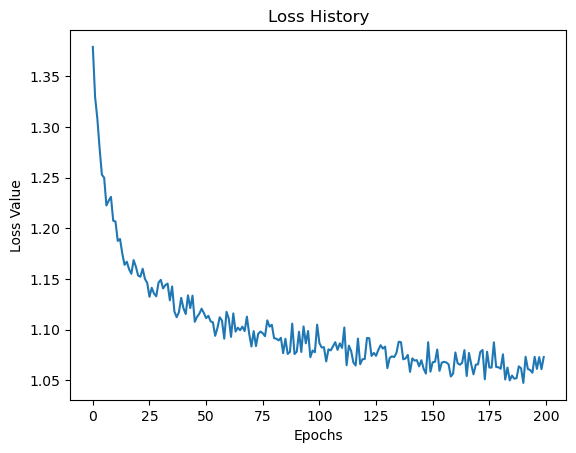

In [19]:
plt.title("Loss History")
plt.plot(range(EPOCHS), loss_list)
plt.xlabel("Epochs")
plt.ylabel("Loss Value")
plt.savefig("figures/train_loss_history_mlp_sgd.pdf", bbox_inches="tight")
plt.show()

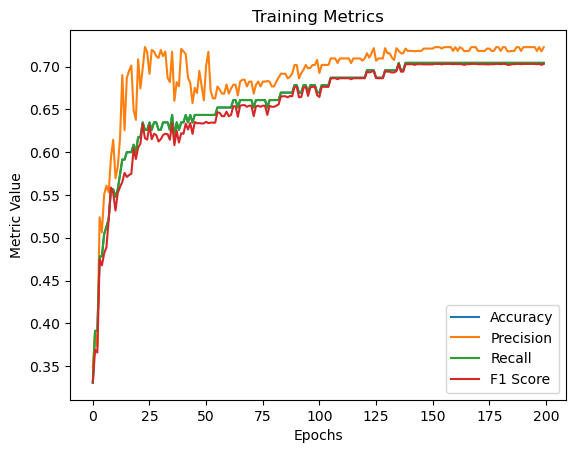

In [20]:
plt.title("Training Metrics")
plt.plot(range(EPOCHS), acc_list, label="Accuracy")
plt.plot(range(EPOCHS), precision_list, label="Precision")
plt.plot(range(EPOCHS), recall_list, label="Recall")
plt.plot(range(EPOCHS), f1_list, label="F1 Score")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Metric Value")
plt.savefig("figures/train_metrics_mlp_sgd.pdf", bbox_inches="tight")
plt.show()

In [25]:
print(f"Mean Training Accuracy: {np.array(acc_list).mean()}")
print(f"Mean Training Precision: {np.array(precision_list).mean()}")
print(f"Mean Training Recall: {np.array(recall_list).mean()}")
print(f"Mean Training F1 Score: {np.array(f1_list).mean()}")

writer.add_scalar("Train/Mean Accuracy", np.array(acc_list).mean(), 0)
writer.add_scalar("Train/Mean Precision", np.array(precision_list).mean(), 0)
writer.add_scalar("Train/Mean Recall", np.array(recall_list).mean(), 0)
writer.add_scalar("Train/Mean F1 Score", np.array(f1_list).mean(), 0)

Mean Training Accuracy: 0.6625652173913043
Mean Training Precision: 0.6911504166513684
Mean Training Recall: 0.6625652173913043
Mean Training F1 Score: 0.65727885650852


In [26]:
loss = 0.0
accuracy = 0.0
precision = 0.0
recall = 0.0
f1 = 0.0

In [27]:
model.eval()
with torch.no_grad():
  x = torch.tensor(test_data).type(torch.FloatTensor)
  y = torch.tensor(test_labels).type(torch.LongTensor)

  yhat = model(x)

  yhat = yhat.cpu()
  loss = loss_fn(yhat, y)

  yhat = yhat.argmax(1)
  accuracy = accuracy_score(yhat, y)
  precision = precision_score(yhat, y, average='weighted')
  recall = recall_score(yhat, y, average='weighted')
  f1 = f1_score(yhat, y, average='weighted')

In [28]:
print(f"Testing Loss: {loss}")
print(f"Testing Accuracy: {accuracy}")
print(f"Testing Precision: {precision}")
print(f"Testing Recall: {recall}")
print(f"Testing F1 Score: {f1}")

writer.add_scalar("Test/Loss", loss, 0)
writer.add_scalar("Test/Accuracy", accuracy, 0)
writer.add_scalar("Test/Precision", precision, 0)
writer.add_scalar("Test/Recall", recall, 0)
writer.add_scalar("Test/F1 Score", f1, 0)

Testing Loss: 1.4111299514770508
Testing Accuracy: 0.3448275862068966
Testing Precision: 0.3635057471264368
Testing Recall: 0.3448275862068966
Testing F1 Score: 0.33718912666281087


## Adam

In [29]:
model = Model()
model = model.to(DEVICE)
model

Model(
  (dense): Linear(in_features=1440, out_features=4, bias=True)
  (softmax): Softmax(dim=1)
)

In [30]:
tb_board = RUNS_PATH + "mlp_adam"
writer = SummaryWriter(tb_board)

In [31]:
EPOCHS = 200

acc_list = []
f1_list = []
recall_list = []
precision_list = []

loss_list = []

In [32]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [33]:
for epoch in range(EPOCHS):
  model.train()
  running_loss = 0.0

  labels_list = []
  preds_list = []

  for (x, y) in train_loader:
    x, y = x.to(DEVICE), y.to(DEVICE)

    yhat = model(x)

    labels_list.extend(y.cpu())
    preds_list.extend(yhat.argmax(1).cpu())

    loss = loss_fn(yhat, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    running_loss += loss.item()

  avg_loss = running_loss / len(train_loader)
  loss_list.append(avg_loss)

  acc = accuracy_score(labels_list, preds_list)
  pre = precision_score(labels_list, preds_list, average='weighted')
  rec = recall_score(labels_list, preds_list, average='weighted')
  f1 = f1_score(labels_list, preds_list, average='weighted')

  acc_list.append(acc)
  precision_list.append(pre)
  recall_list.append(rec)
  f1_list.append(f1)

  writer.add_scalar("Train/Loss", avg_loss, epoch)
  writer.add_scalar("Train/Accuracy", acc, epoch)
  writer.add_scalar("Train/Precision", pre, epoch)
  writer.add_scalar("Train/Recall", rec, epoch)
  writer.add_scalar("Train/F1", f1, epoch)

  print(f"Epoch: {epoch + 1} - Loss: {avg_loss} - Accuracy: {acc} - Precision: {pre} - Recall: {rec} - F1: {f1}")

Epoch: 1 - Loss: 1.4111050685246787 - Accuracy: 0.25217391304347825 - Precision: 0.26359356585443544 - Recall: 0.25217391304347825 - F1: 0.2569444131373994
Epoch: 2 - Loss: 1.298590032259623 - Accuracy: 0.40869565217391307 - Precision: 0.4200445134575569 - Recall: 0.40869565217391307 - F1: 0.4026189689379454
Epoch: 3 - Loss: 1.2564824024836223 - Accuracy: 0.46956521739130436 - Precision: 0.5248128682911292 - Recall: 0.46956521739130436 - F1: 0.44748702319158057
Epoch: 4 - Loss: 1.2409767945607504 - Accuracy: 0.46956521739130436 - Precision: 0.5152549782330983 - Recall: 0.46956521739130436 - F1: 0.47196497612778837
Epoch: 5 - Loss: 1.2296745459238687 - Accuracy: 0.5391304347826087 - Precision: 0.5917967267834943 - Recall: 0.5391304347826087 - F1: 0.551408171964438
Epoch: 6 - Loss: 1.1725375771522522 - Accuracy: 0.5739130434782609 - Precision: 0.6121814092953524 - Recall: 0.5739130434782609 - F1: 0.5829886737303617
Epoch: 7 - Loss: 1.174102512995402 - Accuracy: 0.591304347826087 - Precis

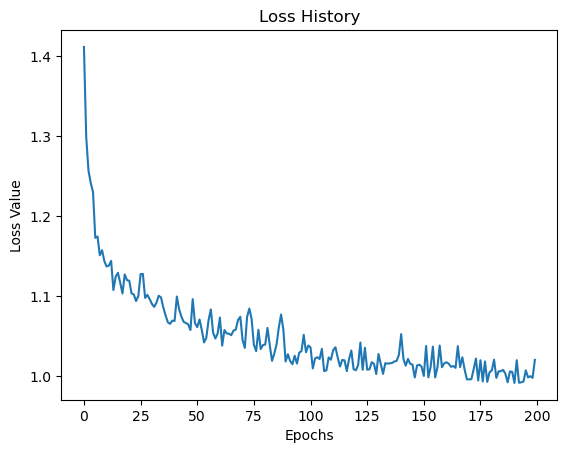

In [34]:
plt.title("Loss History")
plt.plot(range(EPOCHS), loss_list)
plt.xlabel("Epochs")
plt.ylabel("Loss Value")
plt.savefig("figures/training_loss_history_mlp_adam.pdf", bbox_inches="tight")
plt.show()

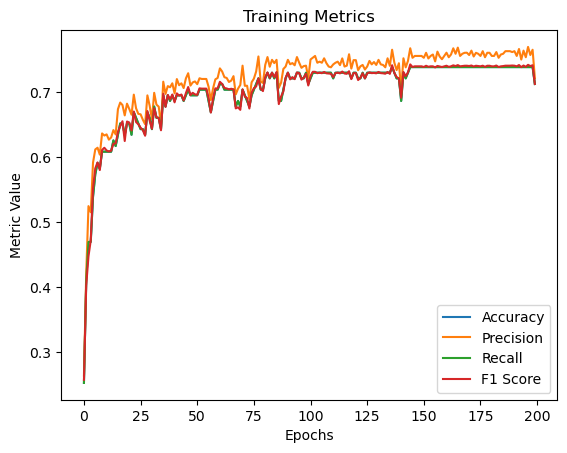

In [35]:
plt.title("Training Metrics")
plt.plot(range(EPOCHS), acc_list, label="Accuracy")
plt.plot(range(EPOCHS), precision_list, label="Precision")
plt.plot(range(EPOCHS), recall_list, label="Recall")
plt.plot(range(EPOCHS), f1_list, label="F1 Score")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Metric Value")
plt.savefig("figures/training_metrics_mlp_adam.pdf", bbox_inches="tight")
plt.show()

In [36]:
print(f"Mean Training Accuracy: {np.array(acc_list).mean()}")
print(f"Mean Training Precision: {np.array(precision_list).mean()}")
print(f"Mean Training Recall: {np.array(recall_list).mean()}")
print(f"Mean Training F1 Score: {np.array(f1_list).mean()}")

writer.add_scalar("Train/Mean Accuracy", np.array(acc_list).mean(), 0)
writer.add_scalar("Train/Mean Precision", np.array(precision_list).mean(), 0)
writer.add_scalar("Train/Mean Recall", np.array(recall_list).mean(), 0)
writer.add_scalar("Train/Mean F1 Score", np.array(f1_list).mean(), 0)

Mean Training Accuracy: 0.7018260869565218
Mean Training Precision: 0.7217657850780076
Mean Training Recall: 0.7018260869565218
Mean Training F1 Score: 0.7024844160421599


In [40]:
loss = 0.0
accuracy = 0.0
precision = 0.0
recall = 0.0
f1 = 0.0

In [41]:
model.eval()
with torch.no_grad():
  x = torch.tensor(test_data).type(torch.FloatTensor)
  y = torch.tensor(test_labels).type(torch.LongTensor)

  yhat = model(x)

  yhat = yhat.cpu()
  loss = loss_fn(yhat, y)

  yhat = yhat.argmax(1)
  accuracy = accuracy_score(yhat, y)
  precision = precision_score(yhat, y, average='weighted')
  recall = recall_score(yhat, y, average='weighted')
  f1 = f1_score(yhat, y, average='weighted')

In [42]:
print(f"Testing Loss: {loss}")
print(f"Testing Accuracy: {accuracy}")
print(f"Testing Precision: {precision}")
print(f"Testing Recall: {recall}")
print(f"Testing F1 Score: {f1}")

writer.add_scalar("Test/Loss", loss, 0)
writer.add_scalar("Test/Accuracy", accuracy, 0)
writer.add_scalar("Test/Precision", precision, 0)
writer.add_scalar("Test/Recall", recall, 0)
writer.add_scalar("Test/F1 Score", f1, 0)

Testing Loss: 1.4016281366348267
Testing Accuracy: 0.3103448275862069
Testing Precision: 0.3247126436781609
Testing Recall: 0.3103448275862069
Testing F1 Score: 0.31102690413035244
